https://www.youtube.com/watch?v=8N-nM3QW7O0&list=PLIyykJUunUQMPRIZudEdKLwvVs2g9S6m-&index=29

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data.csv",parse_dates=["posted","scraped"])

df["target"] = np.log(df.upvotes+1)
df = df[["title","target","test"]]

train = df.loc[~df.test]
test = df.loc[df.test]

test["target"] -= train.target.mean()
test["target"]  /= train.target.std()
train["target"]  -= train.target.mean()
train["target"]  /= train.target.std()

C:\Users\alexi\AppData\Local\Temp/ipykernel_17404/3370013509.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"] -= train.target.mean()
C:\Users\alexi\AppData\Local\Temp/ipykernel_17404/3370013509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"]  /= train.target.std()
C:\Users\alexi\AppData\Local\Temp/ipykernel_17404/3370013509.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

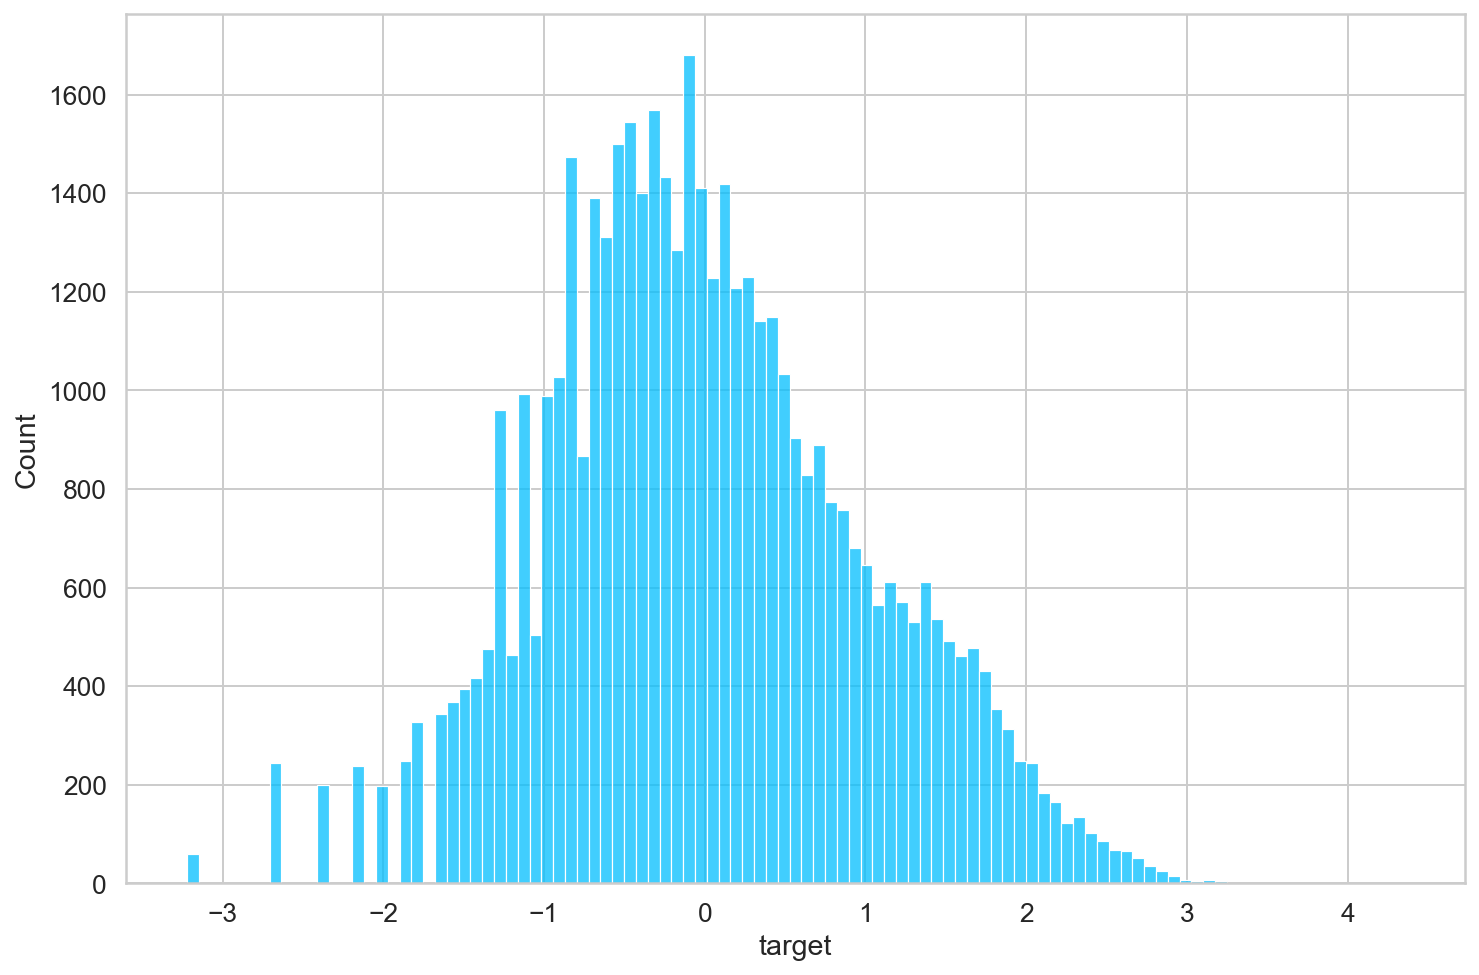

In [22]:
sns.histplot(data=train,x="target");

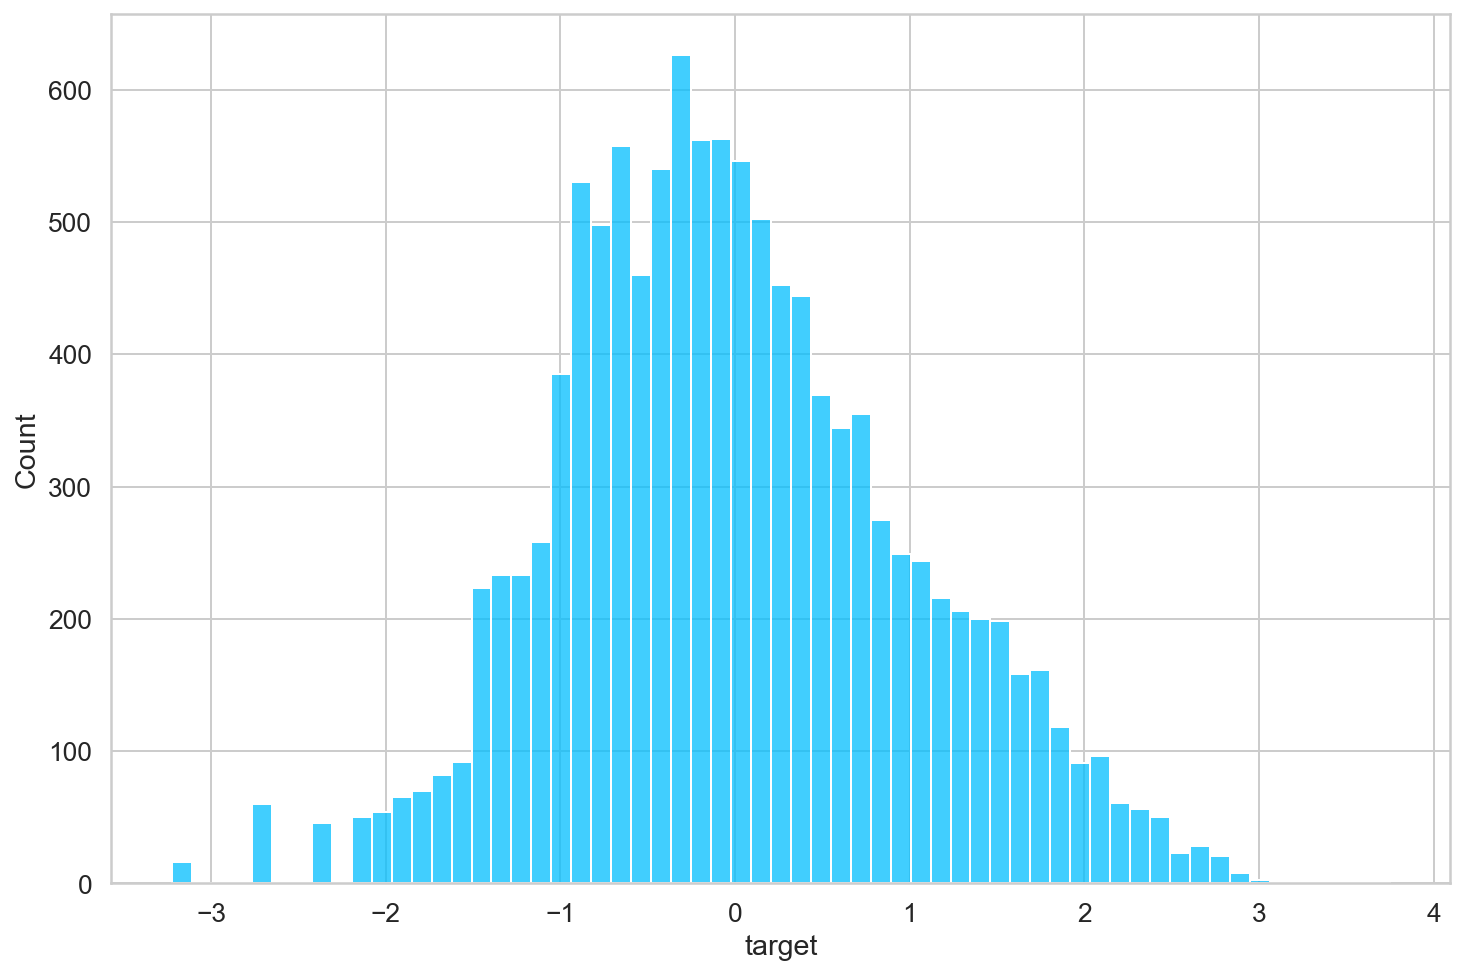

In [23]:
sns.histplot(data=test,x="target");

In [5]:
!pip install -q -U watermark

In [6]:
!pip install -qq transformers

In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.21.2
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.21.0



In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [5]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [6]:
MAX_LEN = 30

In [13]:
class RedditDataset(Dataset):

    def __init__(self, title, targets, tokenizer, max_len):
        self.title = title
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.title)
  
    def __getitem__(self, item):
        title = str(self.title[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          title,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'title': title,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target)
        }

In [14]:
train, val = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

In [15]:
BS = 8

In [16]:
trainset = RedditDataset(title=train.title.to_numpy(),targets=train.target.to_numpy(),tokenizer=tokenizer,max_len=MAX_LEN)
valset = RedditDataset(title=val.title.to_numpy(),targets=val.target.to_numpy(),tokenizer=tokenizer,max_len=MAX_LEN)
testset = RedditDataset(title=test.title.to_numpy(),targets=test.target.to_numpy(),tokenizer=tokenizer,max_len=MAX_LEN)

In [17]:
trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
valloader = DataLoader(valset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [18]:
data = next(iter(trainloader))
data.keys()

dict_keys(['title', 'input_ids', 'attention_mask', 'targets'])

In [19]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 30])
torch.Size([8, 30])
torch.Size([8])


In [20]:
model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
model.train()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [58]:
output=model( input_ids=data['input_ids'], 
  attention_mask=data['attention_mask'])

In [64]:
output[0].shape

torch.Size([16, 30, 768])

In [65]:
output[1].shape

torch.Size([16, 768])

In [66]:
model.config.hidden_size

768

In [21]:
class PhotoRater(nn.Module):

    def __init__(self):
        super(PhotoRater, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Sequential(nn.Linear(self.bert.config.hidden_size,10)
                                ,nn.Dropout(0.3)
                                 ,nn.ReLU()
                                 ,nn.Linear(10,1)
                                )
  
    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        output = self.drop(output[1])
        return self.out(output)

In [22]:
model = PhotoRater()
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
from tqdm.notebook import tqdm

In [25]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(trainloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)

In [34]:
def train_epoch(model,dataloader,loss_fn,optimizer,device,scheduler):
    
    model = model.train()

    losses = []

    for d in tqdm(dataloader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        loss = (((outputs-targets)**2).mean())**0.5
        

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses)

In [32]:
def eval_model(model, dataloader, loss_fn, device):
  
    model = model.eval()

    losses = []

    with torch.no_grad():
        for d in dataloader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )

            loss = (((outputs-targets)**2).mean())**0.5

            losses.append(loss.item())

    return np.mean(losses)

In [33]:
print(f'Baseline: {np.sqrt(((val.target-val.target.mean())**2).mean())}')

Baseline: 1.0023135390568283


In [35]:
best_loss = np.inf
history = defaultdict(list)

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss = train_epoch(
    model,
    trainloader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
    )

    print(f'Train loss: {train_loss}')

    val_loss = eval_model(
    model,
    valloader,
    loss_fn, 
    device
    )

    print(f'Val loss: {val_loss}')
    print()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_loss = val_loss

Epoch 1/5
----------


  0%|          | 0/3739 [00:00<?, ?it/s]

Train loss: 0.9756162608611225
Val loss: 0.972339232165391

Epoch 2/5
----------


  0%|          | 0/3739 [00:00<?, ?it/s]

Train loss: 0.9746267908799933
Val loss: 0.9741682672085108

Epoch 3/5
----------


  0%|          | 0/3739 [00:00<?, ?it/s]

Train loss: 0.9724540799888429
Val loss: 0.9719861679586479

Epoch 4/5
----------


  0%|          | 0/3739 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
np.sqrt(val_loss)

0.6874411578685433